# 140. User-Item based Collaborative Filtering - Matrix Factorization

## Keras로 MF(Matrix Factorization) 구현하기 - GPU 필요 / Colab 사용


### MF 방식의 원리

<img src="https://petamind.com/wp-content/uploads/2019/12/ml-mf-matrix-factorization-_op.svg" width=400 />

$$R \approx P\times Q^T=\hat{R}$$

R: Rating matrix, P: User latent matrix, Q: Item latent matrix, k: latent factor(잠재 요인), $\hat{R}$: 예측값

- R 행렬의 각 element는 해당 사용자 아이템에 대한 평점. 이 행렬은 사용자가 실제로 평가한 아이템에 대한 평점만을 가지고 있으므로 많은 원소가 null 로 채워진 sparse matrix 이다.
- R 행렬을 사용자 행렬 (P)와 아이템 행렬(Q)로 쪼개어 분석하는 방법이  MF  
- $\hat{R}$이 최대한 R에 가까운 값을 가지도록 하는 P와 Q를 구하면 그 것이 바로 추천을 위한 model이 된다.

$$\hat{r_{ij}}=b+bu_i + bd_j + \sum_{k=1}^k{p_{ik}q_{kj}}$$

$\hat{r_{ij}}$: 사용자 i 의 아이템 j 에  대한 예측값,  
b: 전체 평균. 일단 데이터가 주어지면 하나로 정해지는 값   
$bu_i$: 전체 평균을 제거한 후 사용자 i의 평가 경향(사용자 i의 평균과 전체 평균의 차이)     
$bd_j$: 전체 평균을 제거한 후 아이템 j의 평가 경향(아이템 j의 평균과 전체 평균의 차이)   
$p_{ik}$: 행렬 P의 i 번째 사용자 vector    
$q_{kj}$: 행렬 Q의 column j 번째 item vector

### MF 를 신경망으로 구현

<img src="https://ichi.pro/assets/images/max/724/1*VqQ5B6ah4KhbDKNBgX-cfg.png" />

- Input Layer 는 one-hot-encoding 과 같다.
- Embedding Layer 는 latent factor d 에 해당.  
- 사용자와 아이템의 경향성(bias)을 feature 가 1 인  Embedding 으로 구현  
- 전체 평균(b)는 하나의 숫자이므로 신경망의 target value에서 일률적으로 빼 주고, 나중에 산출된 예측치에 일률적으로 더해주는 것이 전체 평균을 모델화 하는 것 보다 간단함.

In [1]:
# 필요한 library import
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten,  Concatenate, Dense

# 평점 데이터를 URL로부터 불러옵니다. r_cols는 열 이름을 정의합니다.
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
url = "https://raw.githubusercontent.com/ironmanciti/Recommenders_Lecture/main/data/u.rating"
ratings = pd.read_csv(url, names=r_cols, sep='\t', encoding='latin-1')

# 'timestamp' 열을 제거하고, 'user_id', 'movie_id', 'rating' 열만 남깁니다.
# 데이터 타입을 int로 변환하여 정수형 데이터로 처리합니다.
ratings = ratings[['user_id', 'movie_id', 'rating']].astype(int)
ratings.head()

,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [2]:
# 사용자 데이터를 URL로부터 불러옵니다. u_cols는 열 이름을 정의합니다.
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
url = "https://raw.githubusercontent.com/ironmanciti/Recommenders_Lecture/main/data/u.user"
users = pd.read_csv(url, sep='|', names=u_cols, encoding='latin-1')
users.head()

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [3]:
# 필요한 열만 선택합니다.
users = users[['user_id', 'age', 'sex']]

# 'age' 열을 'age'의 최대값으로 나누어 0과 1 사이의 값으로 정규화합니다.
users['age'] = users['age'] / users['age'].max()
users.head()

<ipython-input-3-b7fe8f9477ab>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users['age'] = users['age'] / users['age'].max()


,user_id,age,sex
0,1,0.328767,M
1,2,0.726027,F
2,3,0.315068,M
3,4,0.328767,M
4,5,0.452055,F


In [4]:
# 'user_id'를 기준으로 'ratings' 데이터프레임과 'users' 데이터프레임을 병합합니다.
# 이 과정을 통해 각 평점 데이터에 해당 사용자의 정보가 추가됩니다.
ratings = pd.merge(ratings, users, on='user_id')
ratings

,user_id,movie_id,rating,age,sex
0,196,242,3,0.671233,M
1,196,393,4,0.671233,M
2,196,381,4,0.671233,M
3,196,251,3,0.671233,M
4,196,655,5,0.671233,M
...,...,...,...,...,...
99995,941,919,5,0.273973,M
99996,941,273,3,0.273973,M
99997,941,1,5,0.273973,M
99998,941,294,4,0.273973,M


In [5]:
# 원-핫 인코딩을 적용하여 범주형 변수를 수치형으로 변환합니다.
ratings = pd.get_dummies(ratings)
ratings.head()

,user_id,movie_id,rating,age,sex_F,sex_M
0,196,242,3,0.671233,False,True
1,196,393,4,0.671233,False,True
2,196,381,4,0.671233,False,True
3,196,251,3,0.671233,False,True
4,196,655,5,0.671233,False,True


In [6]:
# ratings 데이터프레임에서 'rating' 열을 제거하고, 이를 target_ratings에 저장
target_ratings = ratings.pop('rating')

In [7]:
ratings.head(2)

,user_id,movie_id,age,sex_F,sex_M
0,196,242,0.671233,False,True
1,196,393,0.671233,False,True


In [8]:
# 'ratings' 데이터프레임에서 첫 두 열을 제외한 나머지 열들을 선택하고,
# 열의 수를 'others_input_shape' 변수에 저장합니다.
# 이는 모델의 입력으로 사용될 기타 특성의 차원 수를 지정에 사용합니다.
others_input_shape = ratings.iloc[:, 2:].values.shape[1]
others_input_shape

3

In [9]:
# train test set 분리
train_ratings, test_ratings, train_targets, test_targets = train_test_split(ratings, target_ratings, test_size=0.2, random_state=0)
train_ratings.shape, test_ratings.shape, train_targets.shape, test_targets.shape

((80000, 5), (20000, 5), (80000,), (20000,))

In [10]:
# 잠재 요인(latent factor)의 수를 설정합니다.
K = 100

# 훈련 데이터셋에서 평점의 평균을 계산합니다. 이 평균값은 추천 시스템의 기준선(baseline) 평가로 사용됩니다.
mu = train_targets.mean()

# 사용자 수를 계산합니다. user_id의 최대값에 1을 더함으로써 0부터 시작하는 인덱스를 맞춥니다.
M = ratings.user_id.max() + 1

# 영화 수를 계산합니다. movie_id의 최대값에 1을 더함으로써 0부터 시작하는 인덱스를 맞춥니다.
N = ratings.movie_id.max() + 1

# 계산된 값을 출력합니다.
K, mu, M, N

(100, 3.53185, 944, 1683)

In [11]:
# 사용자 임베딩의 shape 확인
# 사용자 수(M)와 잠재 요인의 수(K)를 기반으로 한 임베딩 행렬에서
# 하나의 사용자 임베딩 벡터를 가져온 후 그 shape을 출력
Embedding(M, K)(0).shape

TensorShape([100])

### Shallow Neural Network

<img src="https://petamind.com/wp-content/uploads/2019/12/ml-mf-matrix-factorization-_op.svg" width=400 />

$$\hat{r}_{ij} = b + bu_i + bd_i + \sum_1^k{p_{ik}q_{jk}}$$
  
k :  잠재 요인(latent factor)의 수   
$\hat{r}_{ij}$ : 사용자 i의 아이템 j에 대한 예측값  
b : 전체 평균 (데이터가 주어지면 하나로 정해지는 상수)  
$bu_i$ : 전체 평균을 제거한 후 사용자 i의 평가 경향 (사용자 i의 평균과 전체 평균의 차이)  
$bd_i$ : 전체 평균을 제거한 후 아이텐 j의 평가 경향 (아이템 j의 평균과 전체 평균의 차이)  
$p_{ik}$ : 행렬 P의 i번째 사용자 vector  
$q_{jk}$ : 행렬 Q의 column j 번째 item vector  

In [12]:
# 사용자 입력 레이어
user = Input(shape=(1, ), name="p_ik")
# Item 입력 레이어
item = Input(shape=(1, ), name="q_kj")
# 기타 특성 입력 레이어
other_features = Input(shape=(others_input_shape,), name="other features")
# 사용자 임베딩 레이어 (M, K)
P_embedding = Embedding(M, K, name="P")(user)
# Item 임베딩 레이어 (N, K)
Q_embedding = Embedding(N, K, name="Q")(item)

# 사용자 편향 (M, 1) 임베딩 레이어
user_bias = Embedding(M, 1, name="bu")(user)
# Item 편향 (N, 1) 임베딩 레이어
item_bias = Embedding(N, 1, name="bd")(item)

# Concatenate를 위해 임베딩 레이어들을 1차원으로 flatten
P_embedding = Flatten()(P_embedding)           #(K,)
Q_embedding = Flatten()(Q_embedding)           #(K,)
user_bias = Flatten()(user_bias)               #(1,)
item_bias = Flatten()(item_bias)               #(1,)

# 4개의 임베딩 레이어와 기타 특성들을 concatenate
x = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias, other_features])
# Hidden Layer로 연결
x = Dense(1024, activation='relu')(x)
x = Dense(64, activation='relu')(x)
Rating = Dense(1)(x)

# 모델 설정
model = Model(inputs=[user, item, other_features], outputs=Rating)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 p_ik (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 q_kj (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 P (Embedding)               (None, 1, 100)               94400     ['p_ik[0][0]']                
                                                                                                  
 Q (Embedding)               (None, 1, 100)               168300    ['q_kj[0][0]']                
                                                                                              

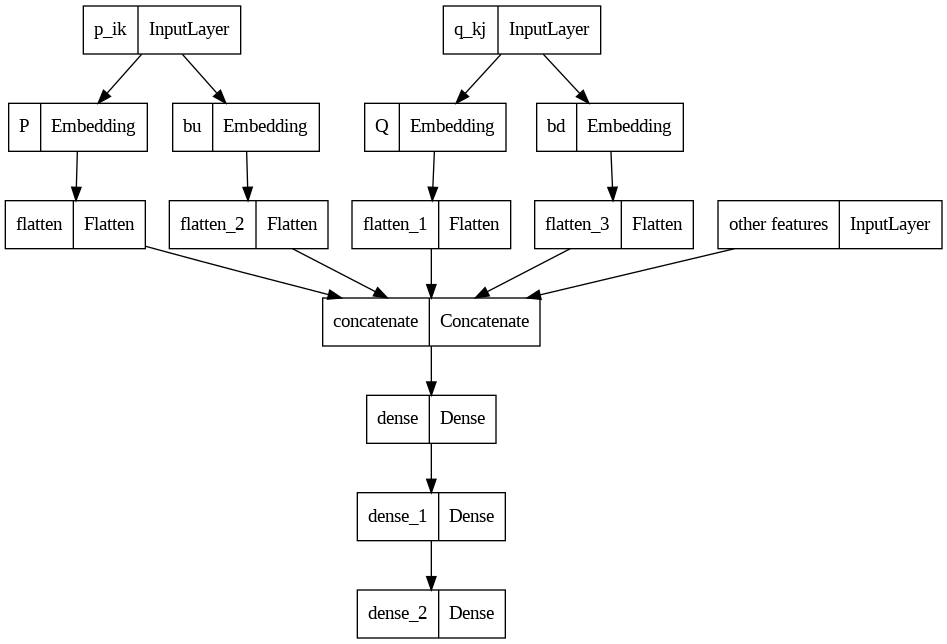

In [13]:
tf.keras.utils.plot_model(model)

In [14]:
model.compile(
  loss="mse",       # 손실 함수로 평균 제곱 오차(MSE) 사용
  optimizer="sgd",  # 최적화 알고리즘으로 확률적 경사 하강법(SGD) 사용
  metrics=["mae"]   # 평가 지표로 MSE 사용
)

In [15]:
# 모델 학습
history = model.fit(
    [
        train_ratings.user_id.values,  # 훈련 데이터의 사용자 ID
        train_ratings.movie_id.values,  # 훈련 데이터의 영화 ID
        train_ratings.iloc[:, 2:].astype('float32').values  # 훈련 데이터의 기타 특성들을 float32 타입으로 변환
    ],
    # 타겟 값에서 전체 평점의 평균을 뺀 값으로, 타입은 float32
    # 이렇게 하는 이유는 데이터의 평균을 0으로 맞추어 학습 성능을 향상시키기 위함.
    train_targets.values.astype('float32') - mu,
    epochs=30,  # 총 30번의 에포크 동안 학습
    batch_size=256,  # 배치 사이즈를 256으로 설정
    validation_data=(
        [
            test_ratings.user_id.values,  # 검증 데이터의 사용자 ID
            test_ratings.movie_id.values,  # 검증 데이터의 영화 ID
            test_ratings.iloc[:, 2:].astype('float32').values  # 검증 데이터의 기타 특성들을 float32 타입으로 변환
        ],
        test_targets.values.astype('float32') - mu  # 검증 타겟 값에서 전체 평점의 평균을 뺀 값으로, 타입은 float32
    )
)

Epoch 1/30
313/313 [==============================] - 15s 36ms/step - loss: 1.2626 - mae: 0.9427 - val_loss: 1.2762 - val_mae: 0.9460
Epoch 2/30
313/313 [==============================] - 3s 11ms/step - loss: 1.2579 - mae: 0.9410 - val_loss: 1.2720 - val_mae: 0.9452
Epoch 3/30
313/313 [==============================] - 2s 7ms/step - loss: 1.2534 - mae: 0.9392 - val_loss: 1.2674 - val_mae: 0.9441
Epoch 4/30
313/313 [==============================] - 2s 7ms/step - loss: 1.2476 - mae: 0.9368 - val_loss: 1.2616 - val_mae: 0.9442
Epoch 5/30
313/313 [==============================] - 2s 6ms/step - loss: 1.2395 - mae: 0.9333 - val_loss: 1.2517 - val_mae: 0.9382
Epoch 6/30
313/313 [==============================] - 2s 8ms/step - loss: 1.2273 - mae: 0.9281 - val_loss: 1.2367 - val_mae: 0.9336
Epoch 7/30
313/313 [==============================] - 3s 9ms/step - loss: 1.2063 - mae: 0.9189 - val_loss: 1.2096 - val_mae: 0.9194
Epoch 8/30
313/313 [==============================] - 2s 6ms/step - loss:

In [16]:
# 모델 평가를 수행합니다.
model.evaluate(
    [
        test_ratings.user_id.values,  # 테스트 데이터의 사용자 ID
        test_ratings.movie_id.values,  # 테스트 데이터의 영화 ID
        test_ratings.iloc[:, 2:].astype('float32').values  # 테스트 데이터의 기타 특성들을 float32 타입으로 변환
    ],
    # 테스트 타겟 값에서 전체 평점의 평균을 뺀 값
    test_targets.values - mu
)

625/625 [==============================] - 1s 2ms/step - loss: 0.8878 - mae: 0.7442


[0.8878342509269714, 0.7442073225975037]

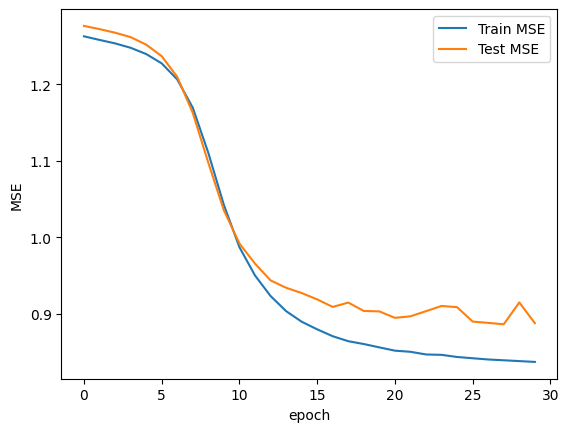

In [17]:
# Plot MSE
plt.plot(history.history['loss'], label="Train MSE")
plt.plot(history.history['val_loss'], label="Test MSE")
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [18]:
# 테스트 세트에서 사용자 ID와 영화 ID, 그리고 기타 특성을 6개 선택
user_ids = test_ratings.user_id.values[10:16]
movie_ids = test_ratings.movie_id.values[10:16]
other_features = test_ratings.iloc[:, 2:].values[10:16]

# 학습된 모델을 사용하여 선택된 샘플에 대한 평점 예측을 수행합니다.
# 예측된 결과에 전체 평점 평균(mu)을 더하여 실제 평점 범위로 변환합니다.
predictions = model.predict([
    user_ids.astype('float32'),
    movie_ids.astype('float32'),
    other_features.astype('float32')
]) + mu

# 실제 평점과 예측 평점을 출력하여 비교
print("Actuals: \n", test_targets.values[10:16])  # 실제 평점 출력
print( )
print("Predictions: \n", predictions)  # 예측 평점 출력

1/1 [==============================] - 0s 299ms/step
Actuals: 
 [4 4 5 2 4 5]

Predictions: 
 [[4.0094953]
 [3.6138382]
 [4.6268835]
 [3.2749915]
 [4.021941 ]
 [3.6274548]]


In [19]:
# 테스트 세트에서 사용자 ID, 영화 ID, 그리고 기타 특성을 전체 선택
user_ids = test_ratings.user_id.values.astype('float32')
movie_ids = test_ratings.movie_id.values.astype('float32')
other_features = test_ratings.iloc[:, 2:].values.astype('float32')

# 모델을 사용하여 전체 테스트 세트에 대한 예측을 수행하고, 전체 평균(mu)을 더해 실제 평점 범위로 변환
y_pred = model.predict([user_ids, movie_ids, other_features]) + mu

# 실제 평점
y_true = test_targets.values

# 실제 값과 예측 값 사이의 평균 제곱 오차(MSE) 계산
mean_squared_error(y_true, y_pred, squared=True)

625/625 [==============================] - 2s 2ms/step


0.887834175426692